In [7]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from wavenet.audiodata import AudioData, AudioLoader
from wavenet.models_torch import Model, Generator
from wavenet.utils import set_args

%matplotlib inline

x_len = 2**15
num_classes = 256
num_layers = 14
num_blocks = 2
num_hidden = 128
kernel_size = 2
learn_rate = 0.001
step_size = 50
gamma = 0.5
batch_size = 8
num_workers = 1
model_file = 'model.pt'
n_new_samples = 1000

## Create dataset and dataloader

In [2]:
filelist = ['assets/classical.wav']

dataset = AudioData(filelist, x_len, num_classes=num_classes, 
                    store_tracks=True)
dataloader = AudioLoader(dataset, batch_size=batch_size, 
                         num_workers=num_workers)

## Define and train model

In [3]:
wave_model = Model(x_len, num_channels=1, num_classes=num_classes, 
                   num_blocks=num_blocks, num_layers=num_layers,
                   num_hidden=num_hidden, kernel_size=kernel_size)
if os.path.isfile(model_file):
    print('Loading model data from file: {}'.format(model_file))
    wave_model.load_state_dict(torch.load(model_file))
else:
    print('Model data not found: {}'.format(model_file))
    print('Training new model.')
    wave_model.criterion = nn.CrossEntropyLoss()
    wave_model.optimizer = optim.Adam(wave_model.parameters(), 
                                      lr=learn_rate)
    wave_model.scheduler = optim.lr_scheduler.StepLR(wave_model.optimizer, 
                                                     step_size=step_size, 
                                                     gamma=gamma)
    
    wave_model.train(dataloader)

    print('Saving model data to file: {}'.format(model_file))
    torch.save(wave_model.state_dict(), model_file)

Loading model data from file: model.pt


/home/masonmcgough/anaconda2/envs/PyTorchSIIM/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


## Predict sequence

In [4]:
wave_generator = Generator(wave_model, dataset)

n_total_samples = x_len + n_new_samples
audio = dataset.tracks[0]['audio'][:n_total_samples]
sample_rate = dataset.tracks[0]['sample_rate']
x = audio[:x_len]
n_predictions = n_total_samples - x_len

print('Predicting {} samples'.format(n_predictions))
y = wave_generator.run(x, n_predictions, disp_interval=100)

Predicting 1000 samples
Sample 0 / 1000
Sample 100 / 1000
Sample 200 / 1000
Sample 300 / 1000
Sample 400 / 1000
Sample 500 / 1000
Sample 600 / 1000
Sample 700 / 1000
Sample 800 / 1000
Sample 900 / 1000


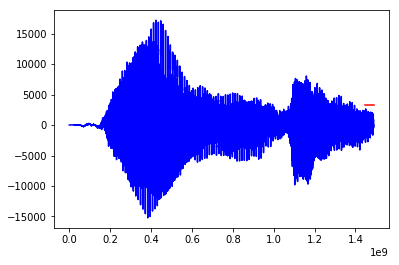

In [11]:
idxs = np.linspace(0, 
                   (n_total_samples - 1) * sample_rate, 
                   n_total_samples)
plt.plot(idxs, audio, 'b')
plt.plot(idxs[x_len:], y, 'r')